# Getting Started

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Load data and dataset modification

In [101]:
DATA_FOLDER = "../../data/"

PREPROCESSED_CHARACTER_DATASET = DATA_FOLDER+"preprocessed_character_metadata_final.tsv"
movies = pd.read_pickle(DATA_FOLDER+'movies.pkl')
character_metadata = pd.read_csv(PREPROCESSED_CHARACTER_DATASET, sep='\t')
character_metadata.columns = ['Wikipedia_movie_ID', 'Freebase_Movie_ID', 'Character_Name',
       'Actor_Ethnicity', 'Actor_Name', 'Actor_Age_At_Movie_Release',
       'Freebase_Character_Actor_Map_ID', 'Freebase_character_ID',
       'Freebase_Actor_ID', 'Movie_Release_Year', 'Ethnicity_Label']

We want to look at the character ethnicity representation depending on the country. Therefore, we can merge the character dataset with the column from the movie dataset containing the country of each film.  

In [102]:
character_countries = pd.merge(character_metadata,movies[['Wikipedia_movie_ID', 'FirstCountry_Name','SecondCountry_Name']], on = 'Wikipedia_movie_ID')
character_countries.sample(5)


,Wikipedia_movie_ID,Freebase_Movie_ID,Character_Name,Actor_Ethnicity,Actor_Name,Actor_Age_At_Movie_Release,Freebase_Character_Actor_Map_ID,Freebase_character_ID,Freebase_Actor_ID,Movie_Release_Year,Ethnicity_Label,FirstCountry_Name,SecondCountry_Name
53086,3595407,/m/09ns2m,NaN,/m/04_hr_,Tanya Chua,25.0,/m/0j89ylk,NaN,/m/09cx6v,2000.0,Chinese Singaporeans,Singapore,None
42819,856716,/m/03hq61,NaN,/m/041rx,Lee Grant,49.0,/m/0k34vp,NaN,/m/039wsf,1975.0,Jewish people,United States of America,None
38629,11926477,/m/083cst,Capt. Ferrone,/m/041rx,Sheldon Leonard,38.0,/m/0cg66kg,/m/0lq34zj,/m/05hrq4,1945.0,Jewish people,United States of America,None
44963,25430565,/m/09k5kmz,Peter,/m/03bkbh,Liam Neeson,56.0,/m/04mm_y3,/m/04mm_y6,/m/0h5g_,2008.0,Irish people,United States of America,United Kingdom
20599,17415776,/m/047lfqr,NaN,/m/07mqps,Van Johnson,30.0,/m/04djhnq,NaN,/m/049tjg,1947.0,Dutch Americans,United States of America,None


## Actor ethnicity in the US vs Rest of the world

We want to analyze the impact of 9/11 on the actor ethnicty within each film. In this purpose we will analyze the actor ethnicity changement befrore and after 9/11. Moreover, we expect for 9/11 to have a higher impact in the US compared to the rest of the world. Therefore, we will compare the data on those levels.

In [103]:
ethnicities_csv = pd.read_csv(DATA_FOLDER+"americans_by_descent.xls")
list_ethnicities = ethnicities_csv.columns[2:]

character = character_countries.copy()
print("length of the dataset: ", len(character))

#Separation into 2 datasets, one with only movies form the US and the other that contains all the other movies
# We use the first and second country associated with the film, if a film second or first country is US he will be in the US dataset otherwise he won't 

character_ROW = character.loc[~character["FirstCountry_Name"].str.contains('United States of America')]
print("length of the ROW dataset: ", len(character_ROW))

character_US = character.loc[character["FirstCountry_Name"].str.contains('United States of America')]
#Look at film which has as first country OR second country United states
additional_US = character_ROW.loc[character_ROW["SecondCountry_Name"].str.contains('United States of America', na=False)]
character_US = pd.concat([character_US, additional_US], ignore_index=True)
character_ROW = character_ROW.loc[~character_ROW.index.isin(additional_US.index)]

#reset the index

character_ROW = character_ROW.reset_index(drop = True)
character_US = character_US.reset_index(drop = True)

length of the dataset:  73797
length of the ROW dataset:  30820


We count the occurence of each ethnicity in both datasets

In [104]:
distribution_ROW = []
distribution_US = []

for eth in list_ethnicities:
    count = character_ROW['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_ROW.append(count)
    count = character_US['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_US.append(count)

In [105]:
ethnicities_dict = {
    'Ethnicity' : list_ethnicities,
    'Rest of the World' : distribution_ROW,
    'United States' : distribution_US
}

ethnicities_distribution = pd.DataFrame(ethnicities_dict)
ethnicities_distribution.head()

,Ethnicity,Rest of the World,United States
0,African,244,8589
1,Arab,7,52
2,Caribbean,1,0
3,European,2,36
4,Greenlandic,0,0


In [106]:
ethnicity_top10_ROW = character_ROW['Ethnicity_Label'].value_counts().nlargest(10)
ethnicity_top10_US = character_US['Ethnicity_Label'].value_counts().nlargest(10)

In [107]:
type(ethnicity_top10_ROW)

pandas.core.series.Series

In [108]:
sorted_ROW = ethnicities_distribution.sort_values(by='Rest of the World', ascending=False).head(10)
ethnicity_top10_ROW = sorted_ROW['Ethnicity'].head(10)
sorted_US = ethnicities_distribution.sort_values(by='United States', ascending=False).head(10)
ethnicity_top10_US = sorted_US['Ethnicity'].head(10)

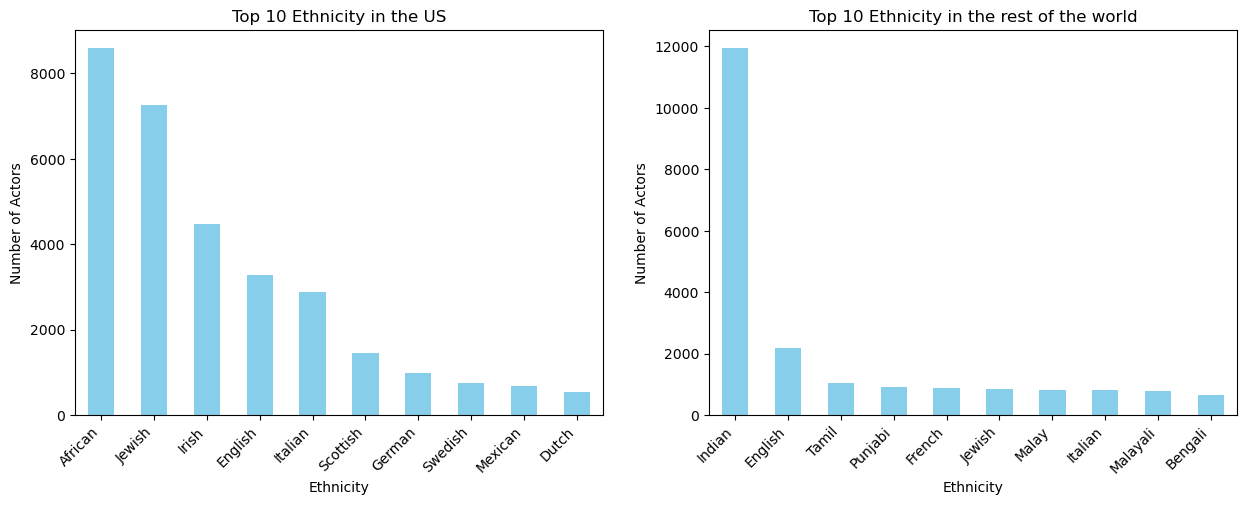

In [109]:
sorted_ROW = ethnicities_distribution.sort_values(by='Rest of the World', ascending=False).head(10)
sorted_US = ethnicities_distribution.sort_values(by='United States', ascending=False).head(10)

ethnicity_top10_ROW = sorted_ROW.set_index('Ethnicity')['Rest of the World']
ethnicity_top10_US = sorted_US.set_index('Ethnicity')['United States']

# Plot the distribution of each ethnicity
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ethnicity_top10_US.plot(kind='bar', color='skyblue')
plt.title("Top 10 Ethnicity in the US")
plt.xlabel("Ethnicity")
plt.ylabel("Number of Actors")
plt.xticks(rotation=45, ha='right')

plt.subplot(1,2,2)
ethnicity_top10_ROW.plot(kind='bar', color='skyblue')
plt.title("Top 10 Ethnicity in the rest of the world")
plt.xlabel("Ethnicity")
plt.ylabel("Number of Actors")
plt.xticks(rotation=45, ha='right')
# plt.subplots_adjust(wspace=0.5)
plt.show()


We observe the top 10 ethnicty in the rest of the world differ from the top 10 ethnicty within the US. The African Americains is the most represented ethnicity in the US whereas in the rest of the world this is the indian. 

### The impact of 9/11

We will now deep into a reduce period of time, between 1993 and 2010 and observe the difference between ethnicities representation in the US compared to the rest of the world. 

In [110]:
# First for the US movies, we will filter the data for movies released between 1993 and 2001 and between 2002 and 2010,
# and study the most common ethnicities for these time periods.

#  Filter data for movies released between 1990 and 2001
data_1993_2001_US = character_US[(character_US['Movie_Release_Year'] >= 1993) & 
                                    (character_US['Movie_Release_Year'] <= 2001)]
data_2002_2010_US = character_US[(character_US['Movie_Release_Year'] >= 2002) & 
                                    (character_US['Movie_Release_Year'] <= 2010)]

# Count the top 10 ethnicities overall
top_ethnicities_US = character_US['Ethnicity_Label'].value_counts().nlargest(10).index

# Filter for only these top ethnicities in each subset
data_1993_2001_top_US = data_1993_2001_US[data_1993_2001_US['Ethnicity_Label'].isin(top_ethnicities_US)]
data_2002_2010_top_US = data_2002_2010_US[data_2002_2010_US['Ethnicity_Label'].isin(top_ethnicities_US)]

# Count occurrences for each ethnicity in each time period
ethnicity_counts_1993_2001_US = data_1993_2001_top_US['Ethnicity_Label'].value_counts(normalize=True)
ethnicity_counts_2002_2010_US = data_2002_2010_top_US['Ethnicity_Label'].value_counts(normalize=True)

We apply the same procedure for the rest of the world

In [111]:
#  Filter data for movies released between 1990 and 2001
data_1993_2001_ROW = character_ROW[(character_ROW['Movie_Release_Year'] >= 1993) & 
                                    (character_ROW['Movie_Release_Year'] <= 2001)]
data_2002_2010_ROW = character_ROW[(character_ROW['Movie_Release_Year'] >= 2002) &
                                    (character_ROW['Movie_Release_Year'] <= 2010)]

# Count the top 10 ethnicities overall
top_ethnicities_ROW = character_ROW['Ethnicity_Label'].value_counts().nlargest(10).index

# Filter for only these top ethnicities in each subset
data_1993_2001_top_ROW = data_1993_2001_ROW[data_1993_2001_ROW['Ethnicity_Label'].isin(top_ethnicities_ROW)]
data_2002_2010_top_ROW = data_2002_2010_ROW[data_2002_2010_ROW['Ethnicity_Label'].isin(top_ethnicities_ROW)]

# Count occurrences for each ethnicity in each time period
ethnicity_counts_1993_2001_ROW = data_1993_2001_top_ROW['Ethnicity_Label'].value_counts(normalize=True)
ethnicity_counts_2002_2010_ROW = data_2002_2010_top_ROW['Ethnicity_Label'].value_counts(normalize=True)

We can now plot the proportion of actor among the 10 most represented ethnicities, for the US and the rest of the world, and compare to see whether there is a different distribution in the two time periods.

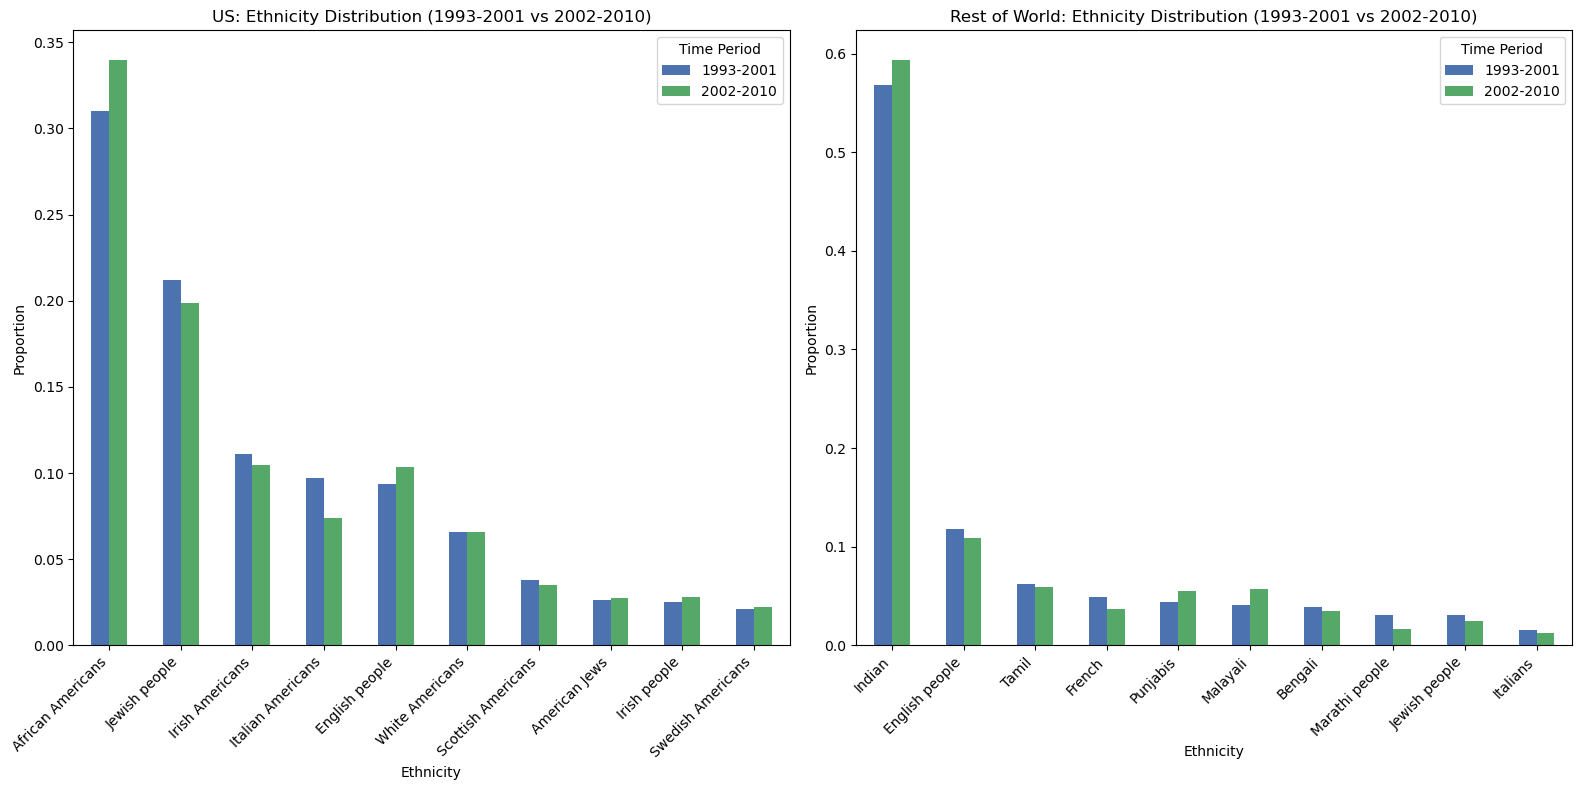

In [112]:

# Convert ethnicity counts to DataFrames for easier plotting
df_US = pd.DataFrame({
    'Ethnicity': ethnicity_counts_1993_2001_US.index,
    '1993-2001': ethnicity_counts_1993_2001_US.values,
    '2002-2010': ethnicity_counts_2002_2010_US.reindex(ethnicity_counts_1993_2001_US.index, fill_value=0).values
})

df_ROW = pd.DataFrame({
    'Ethnicity': ethnicity_counts_1993_2001_ROW.index,
    '1993-2001': ethnicity_counts_1993_2001_ROW.values,
    '2002-2010': ethnicity_counts_2002_2010_ROW.reindex(ethnicity_counts_1993_2001_ROW.index, fill_value=0).values
})

# Set up the plotting style
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot for US
df_US.set_index('Ethnicity').plot(
    kind='bar', ax=axes[0], color=['#4c72b0', '#55a868']
)
axes[0].set_title('US: Ethnicity Distribution (1993-2001 vs 2002-2010)')
axes[0].set_ylabel('Proportion')
axes[0].set_xlabel('Ethnicity')
axes[0].legend(title="Time Period")
axes[0].set_xticklabels(df_US['Ethnicity'], rotation=45, ha="right")

# Plot for Rest of World
df_ROW.set_index('Ethnicity').plot(
    kind='bar', ax=axes[1], color=['#4c72b0', '#55a868']
)
axes[1].set_title('Rest of World: Ethnicity Distribution (1993-2001 vs 2002-2010)')
axes[1].set_ylabel('Proportion')
axes[1].set_xlabel('Ethnicity')
axes[1].legend(title="Time Period")
axes[1].set_xticklabels(df_ROW['Ethnicity'], rotation=45, ha="right")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


We observe there is no major changes in the top 10 actor ethnicities representation in the movies between 1993 and 2010 neither in the rest of the world or the United States.

Finally, we want to isolate the actor ethnicities that exhibit major changes before and after 9/11. Therefore, we will look at the top 10  actor ethnicites that exxhibit larger relative changes ratio. 

In [113]:
# Count the occurrences of each ethnicity in each period for rest of the world and US 
ethnicity_counts_1993_2001_US = data_1993_2001_US['Ethnicity_Label'].value_counts()
ethnicity_counts_2002_2010_US = data_2002_2010_US['Ethnicity_Label'].value_counts()

ethnicity_counts_1993_2001_ROW = data_1993_2001_ROW['Ethnicity_Label'].value_counts()
ethnicity_counts_2002_2010_ROW = data_2002_2010_ROW['Ethnicity_Label'].value_counts()

# We compute the relative changes for each ethnicites between 1991 and 2011
#Use absolute value to avoid the negative value and for subsequnet isolation of smaller and largest relative difference 
ratio_US = np.abs(ethnicity_counts_1993_2001_US - ethnicity_counts_2002_2010_US) / (ethnicity_counts_1993_2001_US)
ratio_ROW = np.abs(ethnicity_counts_1993_2001_ROW - ethnicity_counts_2002_2010_ROW) / (ethnicity_counts_1993_2001_ROW)


# Sort by the ratio to find the largest 
largest_ratios_US = ratio_US.nlargest(10)
largest_ratios_ROW = ratio_ROW.nlargest(10)

print("US: 5 Largest Ratios: \n \n", largest_ratios_US)
print("\n \n Rest of the world: 5 Largest Ratios:\n \n", largest_ratios_ROW)

US: 5 Largest Ratios: 
 
 Ethnicity_Label
Japanese people         25.00
Chinese Canadians       14.00
Ukrainians              13.00
Gujarati people         11.50
Eurasian                11.00
Croatian Canadians       7.00
Dominican Americans      6.75
Norwegians               6.50
Croatian Australians     6.00
Filipino people          6.00
Name: count, dtype: float64

 
 Rest of the world: 5 Largest Ratios:
 
 Ethnicity_Label
Tulu people             27.000000
Chinese Filipino        25.333333
Filipino people         18.000000
Sikh                    13.000000
English Australian      10.000000
Filipino Australians     8.000000
Lao people               8.000000
British Americans        7.000000
Jaat                     6.000000
Ukrainians               6.000000
Name: count, dtype: float64


We observe ratios larger than 1 meaning they exhibit significant differences between the 2 observed periods, i.e before and after 9/11. From this first analysis, we do not observe any tendency of impact of 9/11 on racism. 

# World war 2

We now want to look at another event and there we will look at wolrd war 2. We want to analyze the impact of world war 2 on the actor ethnicty within each film. In this purpose we will analyze the actor ethnicity changement befrore and after world war 2. Moreover, we expect for wolrd war 2 to have a higher impact and earlier in the Europe compared to the US. Therefore, we will compare the data on those levels.

For world war 2 we are interested in the impact on European countries, US and Japan. Therefore, we look inot this 3 group of countries and compare with the rest of the world.

In [114]:
def map_continent(movie_country, continent_data_frame):
    label = continent_data_frame[continent_data_frame['Entity'] == movie_country]['World regions according to OWID']
    if len(label) > 0:
        return label.values[0]
    else:
        return None
continent_mapping_df = pd.read_csv(DATA_FOLDER+"continents.csv",sep=';')
continent_mapping_df.columns = ['Entity','World regions according to OWID']

In [115]:
from tqdm import tqdm

character.reset_index(drop=True, inplace=True)
for i in tqdm(range(len(character))):
    labels = map_continent(character['FirstCountry_Name'].iloc[i], continent_mapping_df)
    labels2 = map_continent(character['SecondCountry_Name'].iloc[i], continent_mapping_df)
    character.at[i, 'Continent'] = labels
    character.at[i,'Second_Continent'] = labels2


100%|██████████| 73797/73797 [00:10<00:00, 6877.96it/s]


In [116]:
character.columns

Index(['Wikipedia_movie_ID', 'Freebase_Movie_ID', 'Character_Name',
       'Actor_Ethnicity', 'Actor_Name', 'Actor_Age_At_Movie_Release',
       'Freebase_Character_Actor_Map_ID', 'Freebase_character_ID',
       'Freebase_Actor_ID', 'Movie_Release_Year', 'Ethnicity_Label',
       'FirstCountry_Name', 'SecondCountry_Name', 'Continent',
       'Second_Continent'],
      dtype='object')

In [117]:
ethnicities_csv = pd.read_csv(DATA_FOLDER+"freebase_mapping.tsv", sep='\t')
print(character.columns)
list_ethnicities = list(set(character['Ethnicity_Label']))
print("length of the dataset: ", len(character))

#Separation into 5 datasets, one for North America, one for South America, one Europe, one Asia and one for Africa
#We chose to separate into 4 datasets in order to have enough data
#Count as many times as necessary an actor if he turned film in different continent
character_EU = character.loc[(character['Continent']=='Europe') | (character['Second_Continent']== 'Europe')]
character_NA = character.loc[(character['Continent']=='North America') | (character['Second_Continent']=='North America')]
character_AS = character.loc[(character['Continent']=='Asia') | (character['Second_Continent']=='Asia')]
character_SA = character.loc[(character['Continent']=='South America') | (character['Second_Continent']=='South America')]
character_AF = character.loc[(character['Continent']=='Africa') | (character['Second_Continent']=='Africa')]

#reset the index
character_EU = character_EU.reset_index(drop = True)
character_NA = character_NA.reset_index(drop = True)
character_AS = character_AS.reset_index(drop = True)
character_SA = character_SA.reset_index(drop = True)
character_AF = character_AF.reset_index(drop = True)


Index(['Wikipedia_movie_ID', 'Freebase_Movie_ID', 'Character_Name',
       'Actor_Ethnicity', 'Actor_Name', 'Actor_Age_At_Movie_Release',
       'Freebase_Character_Actor_Map_ID', 'Freebase_character_ID',
       'Freebase_Actor_ID', 'Movie_Release_Year', 'Ethnicity_Label',
       'FirstCountry_Name', 'SecondCountry_Name', 'Continent',
       'Second_Continent'],
      dtype='object')
length of the dataset:  73797


We count the occurence for each ethnicities in eah of the four dataset:

In [144]:
distribution_NA = []
distribution_AS = []
distribution_SA = []
distribution_AF = []
distribution_EU = []

for eth in list_ethnicities:
    count = character_NA['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_NA.append(count)
    count = character_AS['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_AS.append(count)
    count = character_SA['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_SA.append(count)
    count = character_AF['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_AF.append(count)
    count = character_EU['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_EU.append(count)


In [119]:
ethnicities_dict = {
    'Ethnicity' : list_ethnicities,
    'North America' : distribution_NA,
    'South America' : distribution_SA,
    'Africa' : distribution_AF,
    'Asia' : distribution_AS,
    'Europe' : distribution_EU
}

ethnicities_distribution = pd.DataFrame(ethnicities_dict)
ethnicities_distribution.head()

,Ethnicity,North America,South America,Africa,Asia,Europe
0,Lao people,0,0,0,10,0
1,Sudanese Arabs,3,0,0,0,3
2,Argentines,15,25,0,0,10
3,Quebeckers,1,0,0,1,0
4,Kabyle people,1,0,0,0,2


In [120]:
ethnicity_top10_NA = character_NA['Ethnicity_Label'].value_counts().nlargest(10)
ethnicity_top10_AS = character_AS['Ethnicity_Label'].value_counts().nlargest(10)
ethnicity_top10_SA = character_SA['Ethnicity_Label'].value_counts().nlargest(10)
ethnicity_top10_EU = character_EU['Ethnicity_Label'].value_counts().nlargest(10)
ethnicity_top10_AF = character_AF['Ethnicity_Label'].value_counts().nlargest(10)

In [121]:
sorted_NA = ethnicities_distribution.sort_values(by='North America', ascending=False).head(10)
ethnicity_top10_NA = sorted_NA['Ethnicity'].head(10)
sorted_SA = ethnicities_distribution.sort_values(by='South America', ascending=False).head(10)
ethnicity_top10_SA = sorted_SA['Ethnicity'].head(10)
sorted_AS = ethnicities_distribution.sort_values(by='Asia', ascending=False).head(10)
ethnicity_top10_AS = sorted_AS['Ethnicity'].head(10)
sorted_AF = ethnicities_distribution.sort_values(by='Africa', ascending=False).head(10)
ethnicity_top10_AF = sorted_AF['Ethnicity'].head(10)
sorted_EU = ethnicities_distribution.sort_values(by='Europe', ascending=False).head(10)
ethnicity_top10_EU = sorted_EU['Ethnicity'].head(10)

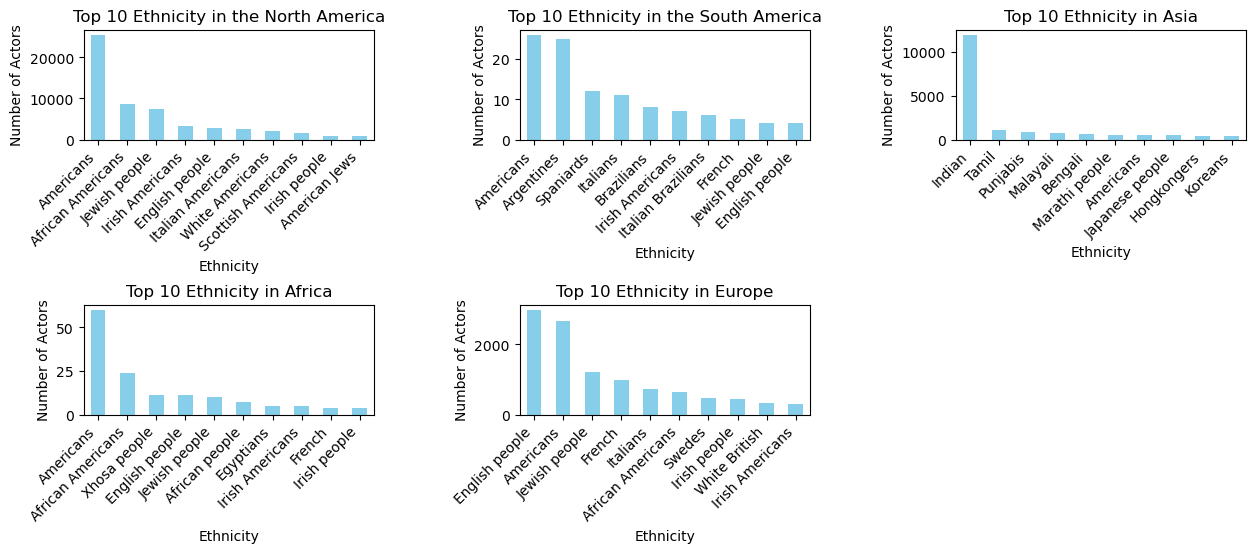

In [122]:
ethnicity_top10_NA = sorted_NA.set_index('Ethnicity')['North America']
ethnicity_top10_SA = sorted_SA.set_index('Ethnicity')['South America']
ethnicity_top10_AF = sorted_AF.set_index('Ethnicity')['Africa']
ethnicity_top10_AS = sorted_AS.set_index('Ethnicity')['Asia']
ethnicity_top10_EU = sorted_EU.set_index('Ethnicity')['Europe']

# Plot the distribution of each ethnicity
plt.figure(figsize=(15,5))
plt.subplot(2,3,1)
ethnicity_top10_NA.plot(kind='bar', color='skyblue')
plt.title("Top 10 Ethnicity in the North America")
plt.xlabel("Ethnicity")
plt.ylabel("Number of Actors")
plt.xticks(rotation=45, ha='right')

plt.subplot(2,3,2)
ethnicity_top10_SA.plot(kind='bar', color='skyblue')
plt.title("Top 10 Ethnicity in the South America")
plt.xlabel("Ethnicity")
plt.ylabel("Number of Actors")
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(wspace=0.5,hspace=1.5)

plt.subplot(2,3,3)
ethnicity_top10_AS.plot(kind='bar', color='skyblue')
plt.title("Top 10 Ethnicity in Asia")
plt.xlabel("Ethnicity")
plt.ylabel("Number of Actors")
plt.xticks(rotation=45, ha='right')

plt.subplot(2,3,4)
ethnicity_top10_AF.plot(kind='bar', color='skyblue')
plt.title("Top 10 Ethnicity in Africa")
plt.xlabel("Ethnicity")
plt.ylabel("Number of Actors")
plt.xticks(rotation=45, ha='right')

plt.subplot(2,3,5)
ethnicity_top10_EU.plot(kind='bar', color='skyblue')
plt.title("Top 10 Ethnicity in Europe")
plt.xlabel("Ethnicity")
plt.ylabel("Number of Actors")
plt.xticks(rotation=45, ha='right')
plt.show()

We want to ensure the presence of so many european in the results are not due to the numerous countries of the film, therefore we look at movies which have only Asia as movie continent. 

In [123]:
character_only_AS = character_AS[character_AS['Continent']=='Asia']
distribution_only_AS = []
for eth in list_ethnicities:
    count = character_only_AS['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_only_AS.append(count)
ethnicities_dict_AS = {
    'Ethnicity' : list_ethnicities,
    'Asia' : distribution_only_AS
}

ethnicities_distribution_AS = pd.DataFrame(ethnicities_dict_AS)
sorted_only_AS = ethnicities_distribution.sort_values(by='Asia', ascending=False).head(10)
print(len(ethnicities_distribution_AS))
ethnicity_top10_only_AS = sorted_only_AS['Ethnicity'].head(10)

ethnicity_top10_only_AS.head(10)

337


9               Indian
130              Tamil
19            Punjabis
80            Malayali
59             Bengali
157     Marathi people
332          Americans
336    Japanese people
280        Hongkongers
155            Koreans
Name: Ethnicity, dtype: object

We observe the top 5 include European, therefore meaning this observed effect is not caused by the presence of multiple countries. 

## Impact of World War 2

We will now deep into a reduce period of time, between 1930 and 1950 and observe the difference between ethnicities representation in the US compared to the rest of the world.

In [124]:
def extract_top_10(df):

    list_ethnicities = list(set(character['Ethnicity_Label']))

    distribution = []

    for eth in list_ethnicities:
        count = df['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
        distribution.append(count)

    ethnicities_dict = {
        'Ethnicity' : list_ethnicities,
        'Occurences' : distribution
    }

    ethnicities_distribution = pd.DataFrame(ethnicities_dict)
    sorted_df = ethnicities_distribution.sort_values(by='Occurences', ascending=False).head(10)
    ethnicity_top10 = sorted_df['Ethnicity'].head(10)

    return ethnicities_distribution, ethnicity_top10

In [125]:
# First for each regions, we will filter the data for movies released between 1937 and 1941 and between 1941 and 1948,
# and study the most common ethnicities for these time periods.
#to get the genre the most impacted, we will choose a small time range to limit cofounding factors
regions = {
    'NA': character_NA,
    'SA': character_SA,
    'AS': character_AS,
    'EU': character_EU,
    'AF': character_AF
}

# Initialize dictionaries to store results for each region
ethnicity_counts_1937_1941 = {}
ethnicity_counts_1942_1948 = {}
data_1937_1948 = {}
ethnicities_distribution = {}
distribution_1937_1941 = {}
distribution_1942_1948 = {}

for region_name, region_data in regions.items():
    # Filter data for the release year ranges
    data_1937_1941 = region_data[
        (region_data['Movie_Release_Year'] >= 1937) & 
        (region_data['Movie_Release_Year'] <= 1941)
    ]
    data_1942_1948 = region_data[
        (region_data['Movie_Release_Year'] >= 1942) & 
        (region_data['Movie_Release_Year'] <= 1948)
    ]
    data_1937_1948[region_name] = region_data[
        (region_data['Movie_Release_Year'] >= 1937) & 
        (region_data['Movie_Release_Year'] <= 1948)
    ]

    # Count the top 10 ethnicities overall for the region
    ethnicities_distribution[region_name], top_ethnicities = extract_top_10(data_1937_1948[region_name])

    # Extract the ethnicity distribution for each time period
    distribution_1937_1941[region_name], _ = extract_top_10(data_1937_1941)
    distribution_1942_1948[region_name], _ = extract_top_10(data_1942_1948)

    # Filter distributions for top ethnicities
    counts_1937_1941 = distribution_1937_1941[region_name][distribution_1937_1941[region_name]['Ethnicity'].isin(top_ethnicities)]
    counts_1942_1948 = distribution_1942_1948[region_name][distribution_1942_1948[region_name]['Ethnicity'].isin(top_ethnicities)]


    # Assign to specific dictionaries using region names
    ethnicity_counts_1937_1941[region_name] = counts_1937_1941
    ethnicity_counts_1942_1948[region_name] = counts_1942_1948

# Separate variables for each region
ethnicity_counts_1937_1941_NA = ethnicity_counts_1937_1941['NA']
ethnicity_counts_1937_1941_SA = ethnicity_counts_1937_1941['SA']
ethnicity_counts_1937_1941_AS = ethnicity_counts_1937_1941['AS']
ethnicity_counts_1937_1941_EU = ethnicity_counts_1937_1941['EU']
ethnicity_counts_1937_1941_AF = ethnicity_counts_1937_1941['AF']

ethnicity_counts_1942_1948_NA = ethnicity_counts_1942_1948['NA']
ethnicity_counts_1942_1948_SA = ethnicity_counts_1942_1948['SA']
ethnicity_counts_1942_1948_AS = ethnicity_counts_1942_1948['AS']
ethnicity_counts_1942_1948_EU = ethnicity_counts_1942_1948['EU']
ethnicity_counts_1942_1948_AF = ethnicity_counts_1942_1948['AF']

ethnicity_counts_1937_1948_NA = data_1937_1948['NA']
ethnicity_counts_1937_1948_SA = data_1937_1948['SA']
ethnicity_counts_1937_1948_AS = data_1937_1948['AS']
ethnicity_counts_1937_1948_EU = data_1937_1948['EU']
ethnicity_counts_1937_1948_AF = data_1937_1948['AF']



We can now plot the proportion of actor among the 10 most represented ethnicities, for the different regions, and compare to see whether there is a different distribution in the five time periods.

In [126]:
# Convert ethnicity counts to DataFrames for easier plotting
df_NA = pd.DataFrame({
    'Ethnicity': ethnicity_counts_1937_1941_NA['Ethnicity'],
    '1937-1941': ethnicity_counts_1937_1941_NA['Occurences'],
    '1942-1948': ethnicity_counts_1942_1948_NA['Occurences']
})

df_SA = pd.DataFrame({
    'Ethnicity': ethnicity_counts_1937_1941_SA['Ethnicity'],
    '1937-1941': ethnicity_counts_1937_1941_SA['Occurences'],
    '1942-1948': ethnicity_counts_1942_1948_SA['Occurences']
})
df_AS = pd.DataFrame({
    'Ethnicity': ethnicity_counts_1937_1941_AS['Ethnicity'],
    '1937-1941': ethnicity_counts_1937_1941_AS['Occurences'],
    '1942-1948': ethnicity_counts_1942_1948_AS['Occurences']
})
df_AF = pd.DataFrame({
    'Ethnicity': ethnicity_counts_1937_1941_AF['Ethnicity'],
    '1937-1941': ethnicity_counts_1937_1941_AF['Occurences'],
    '1942-1948': ethnicity_counts_1942_1948_AF['Occurences']
})
df_EU = pd.DataFrame({
    'Ethnicity': ethnicity_counts_1937_1941_EU['Ethnicity'],
    '1937-1941': ethnicity_counts_1937_1941_EU['Occurences'],
    '1942-1948': ethnicity_counts_1942_1948_EU['Occurences']
})

#We want to isolate the relevant continent, therefore we look at their ethnicity count
regions = {'North Americas':df_NA,'South America': df_SA,'Asia': df_AS,'Africa': df_AF,'Europe': df_EU}
for region_name,region_df in regions.items():

    if region_df['1937-1941'].sum() < 50 or region_df['1942-1948'].sum() < 50:
        print(f"Region: {region_name} has fewer than 50 entries in '1937-1941' or '1942-1948'.")
        



Region: South America has fewer than 50 entries in '1937-1941' or '1942-1948'.
Region: Asia has fewer than 50 entries in '1937-1941' or '1942-1948'.
Region: Africa has fewer than 50 entries in '1937-1941' or '1942-1948'.


We observe South America, Asia and Africa have fewer than 50 entries for the observed period of time making their results unworthy. Therefore for the following plot we will focus on Europe and North America.

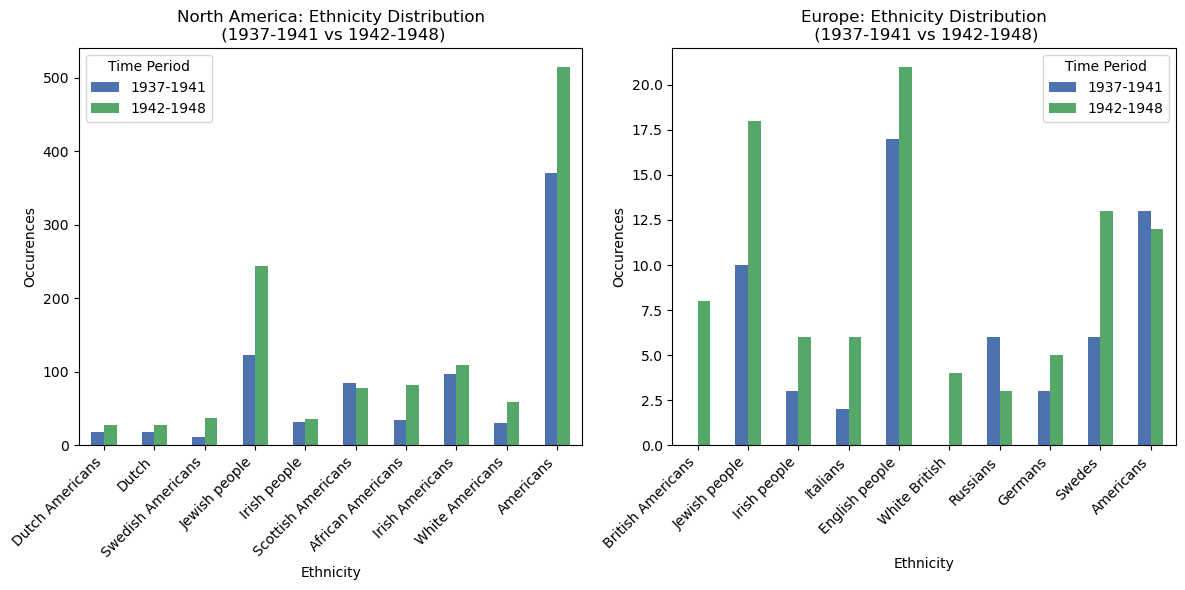

In [127]:
# Set up the plotting style
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.flatten()
regions = [df_NA, df_EU]
titles = [
    'North America: Ethnicity Distribution',
    'Europe: Ethnicity Distribution'
]

# Plot each DataFrame
for i, (df, title) in enumerate(zip(regions, titles)):
    df.set_index('Ethnicity').plot(
        kind='bar',
        ax=axes[i],  # Use flattened axis array
        color=['#4c72b0', '#55a868']
    )
    axes[i].set_title(f'{title}\n (1937-1941 vs 1942-1948)')
    axes[i].set_ylabel('Occurences')
    axes[i].set_xlabel('Ethnicity')
    axes[i].legend(title="Time Period")
    axes[i].set_xticklabels(df['Ethnicity'], rotation=45, ha="right")

# Turn off any unused subplots
for j in range(len(regions), len(axes)):
    axes[j].axis('off')


#  Adjust layout and display the plot

plt.tight_layout()
plt.show()

We now repeat the exact same procedure, but we use proportions instead of absolute occurences. We must do this because we want to work with relative values. There are more movies (and hence more actors) in total in the time period 1942-1948 than in 1937-1941, and we don't want this to influence our analysis on ethnicities.

In [128]:
# Convert ethnicity counts to DataFrames for easier plotting
df_NA_percentage = pd.DataFrame({
    'Ethnicity': ethnicity_counts_1937_1941_NA['Ethnicity'],
    '1937-1941': ethnicity_counts_1937_1941_NA['Occurences']/ethnicity_counts_1937_1941_NA['Occurences'].sum(),
    '1942-1948': ethnicity_counts_1942_1948_NA['Occurences']/ethnicity_counts_1942_1948_NA['Occurences'].sum()
})

df_EU_percentage = pd.DataFrame({
    'Ethnicity': ethnicity_counts_1937_1941_EU['Ethnicity'],
    '1937-1941': ethnicity_counts_1937_1941_EU['Occurences']/ethnicity_counts_1937_1941_EU['Occurences'].sum(),
    '1942-1948': ethnicity_counts_1942_1948_EU['Occurences']/ethnicity_counts_1942_1948_EU['Occurences'].sum()
})

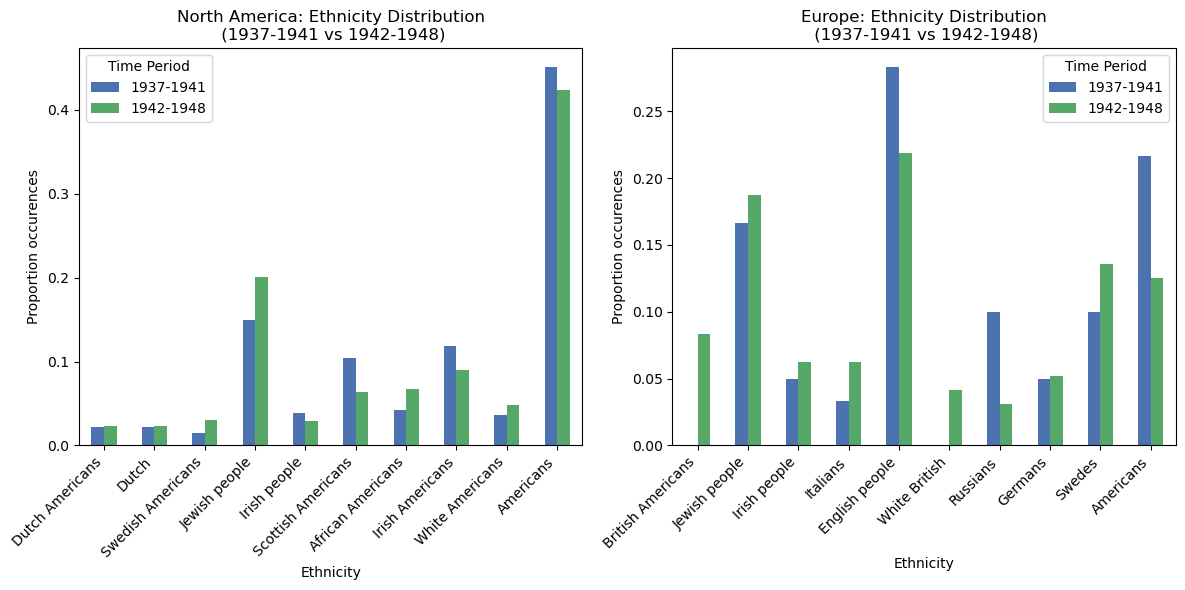

In [129]:
# Set up the plotting style
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.flatten()
regions = [df_NA_percentage, df_EU_percentage]
titles = [
    'North America: Ethnicity Distribution',
    'Europe: Ethnicity Distribution'
]

# Plot each DataFrame
for i, (df, title) in enumerate(zip(regions, titles)):
    df.set_index('Ethnicity').plot(
        kind='bar',
        ax=axes[i],  # Use flattened axis array
        color=['#4c72b0', '#55a868']
    )
    axes[i].set_title(f'{title}\n (1937-1941 vs 1942-1948)')
    axes[i].set_ylabel('Proportion occurences')
    axes[i].set_xlabel('Ethnicity')
    axes[i].legend(title="Time Period")
    axes[i].set_xticklabels(df['Ethnicity'], rotation=45, ha="right")

# Turn off any unused subplots
for j in range(len(regions), len(axes)):
    axes[j].axis('off')


#  Adjust layout and display the plot

plt.tight_layout()
plt.show()

In [132]:
#First we define the dataframe for further ploting based on distribution and percentage
df_NA_ = pd.DataFrame({
    'Ethnicity': distribution_1937_1941['NA']['Ethnicity'],
    '1937-1941': distribution_1937_1941['NA']['Occurences'],
    '1942-1948': distribution_1942_1948['NA']['Occurences']
})
df_NA_percentage_ = pd.DataFrame({
    'Ethnicity': distribution_1937_1941['NA']['Ethnicity'],
    '1937-1941': distribution_1937_1941['NA']['Occurences']/distribution_1937_1941['NA']['Occurences'].sum(),
    '1942-1948': distribution_1942_1948['NA']['Occurences']/distribution_1942_1948['NA']['Occurences'].sum()
})


df_EU_ = pd.DataFrame({
    'Ethnicity': distribution_1937_1941['EU']['Ethnicity'],
    '1937-1941': distribution_1937_1941['EU']['Occurences'],
    '1942-1948': distribution_1942_1948['EU']['Occurences']
})
df_EU_percentage_ = pd.DataFrame({
    'Ethnicity': distribution_1937_1941['EU']['Ethnicity'],
    '1937-1941': distribution_1937_1941['EU']['Occurences']/distribution_1937_1941['EU']['Occurences'].sum(),
    '1942-1948': distribution_1942_1948['EU']['Occurences']/distribution_1942_1948['EU']['Occurences'].sum()
})


In [131]:
from ipywidgets import interact, IntSlider, Dropdown
import plotly.graph_objects as go
from plotly.subplots import make_subplots

sorted_ethnicities = {}

for region_name in regions:
    sorted_ethnicities[region_name] = ethnicities_distribution[region_name].sort_values(by='Occurences', ascending=False)



def update_plot(top_n, location, method):
    if location == 'North America':
        top_ethnicities = sorted_ethnicities['NA'].head(top_n)['Ethnicity']
        data = df_NA_percentage_ if method == 'Proportion' else df_NA_
    if location == 'South America':
        top_ethnicities = sorted_ethnicities['SA'].head(top_n)['Ethnicity']
        data = df_SA_percentage_ if method == 'Proportion' else df_SA_
    if location == 'Asia':
        top_ethnicities = sorted_ethnicities['AS'].head(top_n)['Ethnicity']
        data = df_AS_percentage_ if method == 'Proportion' else df_AS_
    if location == 'Africa':
        top_ethnicities = sorted_ethnicities['AF'].head(top_n)['Ethnicity']
        data = df_AF_percentage_ if method == 'Proportion' else df_AF_
    else:
        top_ethnicities = sorted_ethnicities['EU'].head(top_n)['Ethnicity']
        data = df_EU_percentage_ if method == 'Proportion' else df_EU_
    
    
    # Filter data to include only the top N ethnicities
    filtered_data = data[data['Ethnicity'].isin(top_ethnicities)].copy()

    # Ensure Ethnicity is ordered based on top_ethnicities
    filtered_data['Ethnicity'] = pd.Categorical(
        filtered_data['Ethnicity'], categories=top_ethnicities, ordered=True
    )
    filtered_data = filtered_data.sort_values(by='Ethnicity')

    # Create figure
    fig = make_subplots(rows=1, cols=1)
    fig.add_trace(go.Bar(
        x=filtered_data['Ethnicity'],
        y=filtered_data['1937-1941'],
        name='1937-1941',
        marker_color='#4c72b0'
    ))
    fig.add_trace(go.Bar(
        x=filtered_data['Ethnicity'],
        y=filtered_data['1942-1948'],
        name='1942-1948',
        marker_color='#55a868'
    ))

    # Update layout
    fig.update_layout(
        title=f"{location}: Ethnicity Distribution ({method})",
        xaxis_title="Ethnicity",
        yaxis_title="Proportion" if method == 'Proportion' else "Number of actors",
        barmode='group',
        xaxis_tickangle=-45,
        height=600
    )
    return fig

def interactive_plot(top_n, location, method, updatePlot = 0):

    dumb_variable = 0

    fig = update_plot(top_n, location, method)

    if updatePlot != 0:
        fig.show()
        dumb_variable = 1

    if updatePlot == 0: # remove the plot from the output
        # plot an empty figure
        fig = go.Figure()
        if dumb_variable != 0:
            fig.show()
        


# Use interact with the updated interactive function
interact(
    interactive_plot,
    top_n=IntSlider(min=1, max=30, step=1, value=10, description='Top Ethnicities'),
    location=Dropdown(options=['North America', 'South America', 'Africa', 'Asia', 'Europe'], value='North America', description='Location'),
    method=Dropdown(options=['Number of actors', 'Proportion'], value='Number of actors', description='Method')
)


ModuleNotFoundError: No module named 'plotly'

In [133]:
# Define a new column for the variation (in %)
df_NA['Ratio'] = -(df_NA['1937-1941'] - df_NA['1942-1948']) / (df_NA['1937-1941'])
df_EU['Ratio'] = -(df_EU['1937-1941'] - df_EU['1942-1948']) / (df_EU['1937-1941'])

# Sort by the ratio to find the largest 
largest_ratios_NA = df_NA.sort_values(by='Ratio', ascending=False).head(5)
largest_ratios_EU = df_EU.sort_values(by='Ratio', ascending=False).head(5)

print("North America: 5 Largest Ratios: \n \n", largest_ratios_NA)
print("\n \n Europe: 5 Largest Ratios:\n \n", largest_ratios_EU)

North America: 5 Largest Ratios: 
 
              Ethnicity  1937-1941  1942-1948     Ratio
111  Swedish Americans         12         37  2.083333
190  African Americans         35         82  1.342857
116      Jewish people        123        244  0.983740
225    White Americans         30         59  0.966667
41     Dutch Americans         18         28  0.555556

 
 Europe: 5 Largest Ratios:
 
              Ethnicity  1937-1941  1942-1948     Ratio
49   British Americans          0          8       inf
237      White British          0          4       inf
180           Italians          2          6  2.000000
326             Swedes          6         13  1.166667
118       Irish people          3          6  1.000000


World War 2 had a major impact on Jewish and German population. We therefore are now interested to see if this impact is visible on actor ethnicity prevalence before and after World War 2. Therefore, we will investigate the presence of Jewish and German in actor ethnicity before and after Wolrd War 2.

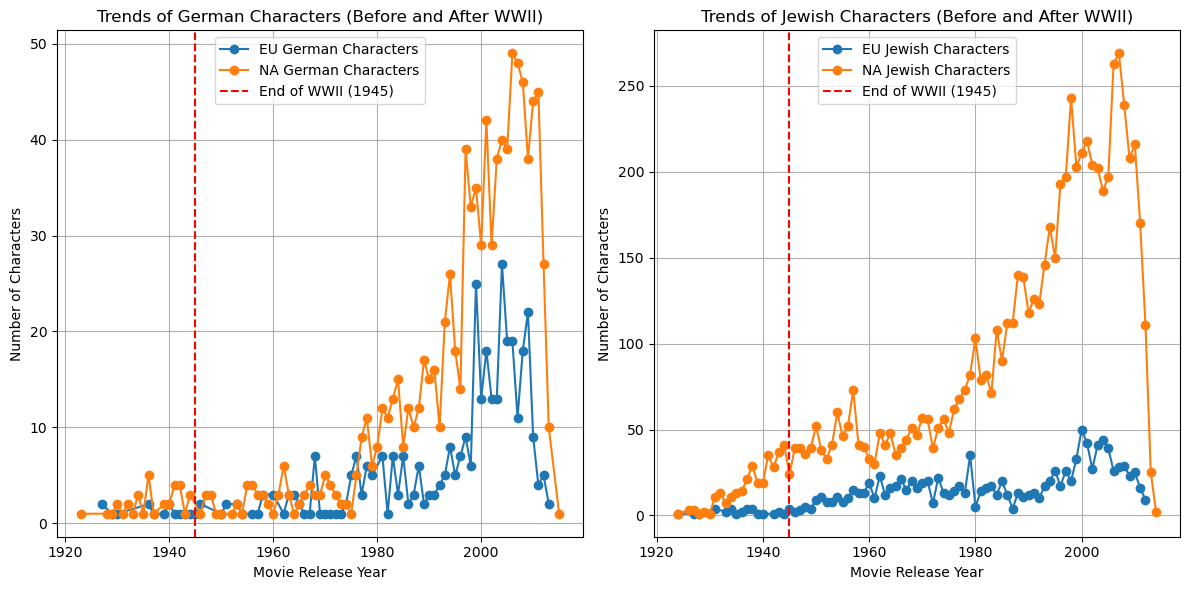

In [154]:
#Isolate European and North American character
character_EU_German = character_EU[character_EU['Ethnicity_Label'].str.contains('German') ]
character_EU_Jewish = character_EU[character_EU['Ethnicity_Label'].str.contains('Jewish')]
character_NA_German = character_NA[character_NA['Ethnicity_Label'].str.contains('German')]
character_NA_Jewish = character_NA[character_NA['Ethnicity_Label'].str.contains('Jewish')]


#Look at the general trend of Jewish and German character before and after world war 2
eu_german_trend = character_EU_German.groupby('Movie_Release_Year').size()
eu_jewish_trend = character_EU_Jewish.groupby('Movie_Release_Year').size()
na_german_trend = character_NA_German.groupby('Movie_Release_Year').size()
na_jewish_trend = character_NA_Jewish.groupby('Movie_Release_Year').size()

# Plot trends
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(eu_german_trend, label='EU German Characters', marker='o')
plt.plot(na_german_trend, label='NA German Characters', marker='o')

plt.title('Trends of German Characters (Before and After WWII)')
plt.xlabel('Movie Release Year')
plt.ylabel('Number of Characters')
plt.axvline(x=1945, color='red', linestyle='--', label='End of WWII (1945)')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(eu_jewish_trend, label='EU Jewish Characters', marker='o')
plt.plot(na_jewish_trend, label='NA Jewish Characters', marker='o')
plt.title('Trends of Jewish Characters (Before and After WWII)')
plt.xlabel('Movie Release Year')
plt.ylabel('Number of Characters')
plt.axvline(x=1945, color='red', linestyle='--', label='End of WWII (1945)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

We will now look using the proportion

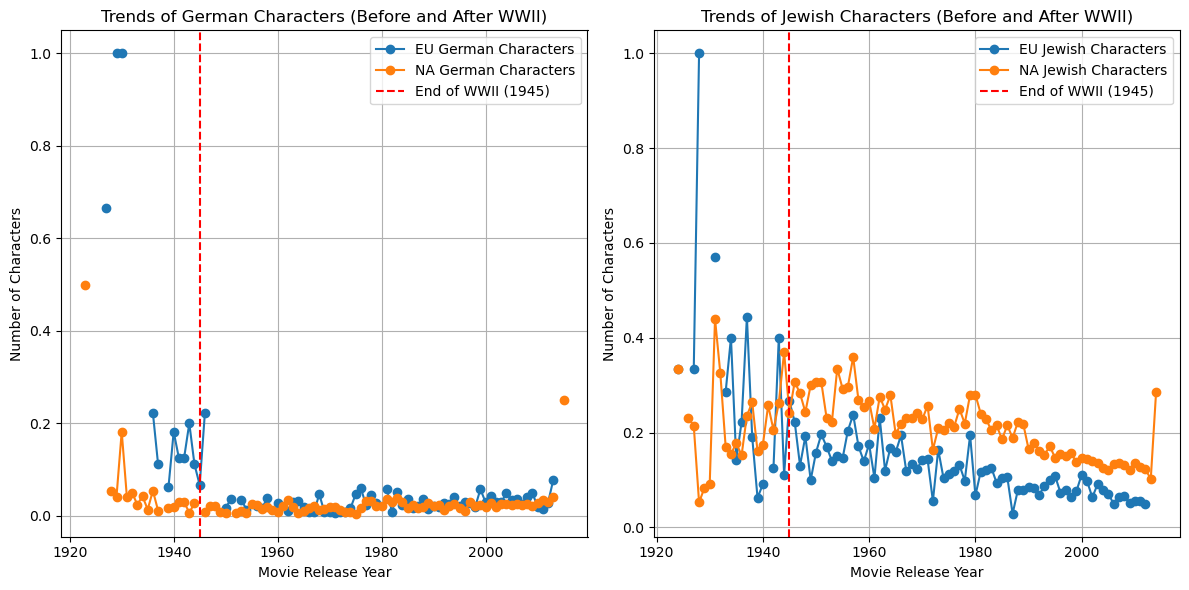

In [155]:
#Look at the general trend of Jewish and German character before and after world war 2
eu_german_trend = character_EU_German.groupby('Movie_Release_Year').size()/character_EU.groupby('Movie_Release_Year').size()
eu_jewish_trend = character_EU_Jewish.groupby('Movie_Release_Year').size()/character_EU.groupby('Movie_Release_Year').size()
na_german_trend = character_NA_German.groupby('Movie_Release_Year').size()/character_NA.groupby('Movie_Release_Year').size()
na_jewish_trend = character_NA_Jewish.groupby('Movie_Release_Year').size()/character_NA.groupby('Movie_Release_Year').size()

# Plot trends
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(eu_german_trend, label='EU German Characters', marker='o')
plt.plot(na_german_trend, label='NA German Characters', marker='o')

plt.title('Trends of German Characters (Before and After WWII)')
plt.xlabel('Movie Release Year')
plt.ylabel('Number of Characters')
plt.axvline(x=1945, color='red', linestyle='--', label='End of WWII (1945)')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(eu_jewish_trend, label='EU Jewish Characters', marker='o')
plt.plot(na_jewish_trend, label='NA Jewish Characters', marker='o')
plt.title('Trends of Jewish Characters (Before and After WWII)')
plt.xlabel('Movie Release Year')
plt.ylabel('Number of Characters')
plt.axvline(x=1945, color='red', linestyle='--', label='End of WWII (1945)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

No sig changes